<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista_de_Exercicio_ARIMA_Seasonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
!pip install pmdarima statsmodels scikit-learn

In [3]:
#!pip install --upgrade scikit-learn pmdarima

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Load Data

In [5]:
df = pd.read_excel('LREN3.BALANCO.xls', sheet_name='Dem. Result.', skiprows=range(0, 1))
#rotacionando a tabela
df = df.T
#settando o cabeçalho com os valores da primeira linha
df.columns = df.iloc[0]
#excluindo a primeira linha
df=df.iloc[1:]
#convertando o formato da data e, posteriormente, atualizando o índice.
df.index = pd.to_datetime(df.index,format='%d/%m/%Y')
df = df.rename(columns={'Resultado Bruto':'y'})
df = df[['y']]
df['y'] = df['y'].astype(float)
#definindo a frequencia do índice
df=df.asfreq('Q-DEC')

WARNING *** file size (90809) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


<ipython-input-5-36c2c8c8433c>:14: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df=df.asfreq('Q-DEC')


<Axes: >

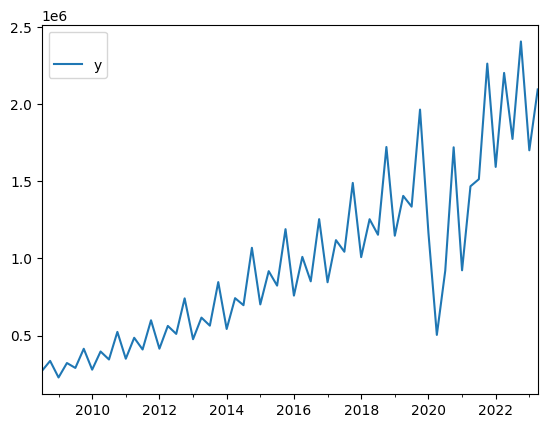

In [6]:
df.plot()

# Normalization

<Axes: >

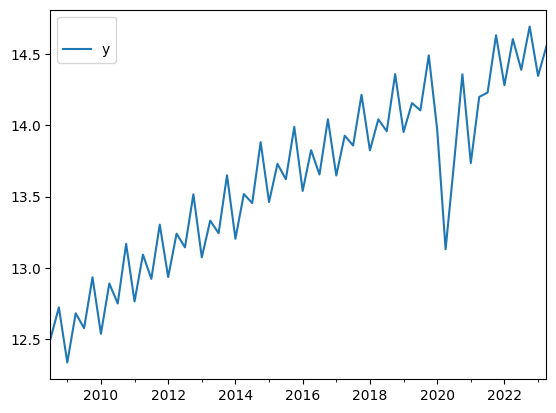

In [7]:
df_log = np.log(df)
df_log.plot()

## Train / Test

In [8]:
size = int(len(df) * 0.7)
train, test = df_log[0:size], df_log[size:len(df)]
h = len(test)
print(train.shape)
print(test.shape)
train.head()

(42, 1)
(18, 1)


,y
2008-09-30,12.500599
2008-12-31,12.722145
2009-03-31,12.334725
2009-06-30,12.680171
2009-09-30,12.575548


# Analysis

In [9]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    dftest = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(dftest[0:4],index=labels)

    for key,val in dftest[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if dftest[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

def kpss_test(serie):
  import statsmodels.api as sm # Importing statsmodels
  from statsmodels.tools.sm_exceptions import InterpolationWarning
  import warnings

  kpss = None
  # Suprimir apenas o InterpolationWarning ao executar o KPSS
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=InterpolationWarning)
    kpss= sm.tsa.stattools.kpss(serie, nlags='auto')[1]

  alpha = 0.05
  print('KPSS test')
  print(f'p-valor = {round(kpss,2)}\nalpha = {round(alpha,2)}')
  if(kpss<=alpha):
      print('Data has a unit root and is non-stationary.')
  else:
      print('Data has no unit root and is stationary.')

def ljungbox_test(serie):
    """
    Aplica o teste de Ljung-Box para verificar autocorrelação nos resíduos.
    """
    from statsmodels.stats.diagnostic import acorr_ljungbox

    ljung_box_results = acorr_ljungbox(serie, return_df=True, lags=[20])

    p_value = ljung_box_results['lb_pvalue'].values[0]
    print('\nLJung-Box Test\nH0:has no autocorrelation\n')
    alpha = 0.05
    print(f'p-valor = {round(p_value,2)}\nalpha = {round(alpha,2)}')
    if p_value < alpha:
        print('Data has autocorrelation')
    else:
        print('Data has no autocorrelation')


In [10]:
adf_test(train)

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.836832
p-value                  0.362335
# lags used              9.000000
# observations          32.000000
critical value (1%)     -3.653520
critical value (5%)     -2.957219
critical value (10%)    -2.617588
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## Definindo 'd'

In [11]:
diff1s = train.copy()
diff1s['y'] = train['y'].diff(4)
diff1s.dropna(inplace=True)
diff1s.head()

,y
2009-09-30,0.074949
2009-12-31,0.211195
2010-03-31,0.201277
2010-06-30,0.209251
2010-09-30,0.173532


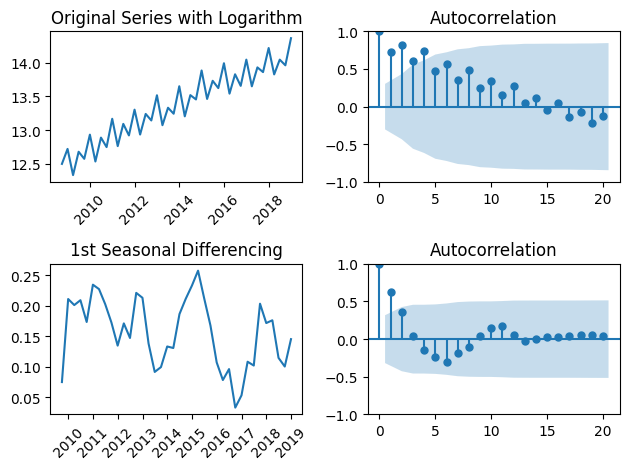

In [12]:
fig, axes = plt.subplots(2, 2, )
axes[0, 0].plot(train); axes[0, 0].set_title('Original Series with Logarithm')
plot_acf(train, ax=axes[0, 1],lags=20)

axes[1, 0].plot(diff1s); axes[1, 0].set_title('1st Seasonal Differencing')
plot_acf(diff1s, ax=axes[1, 1],lags=20)

# Rotaciona os rótulos do eixo X apenas nos gráficos à esquerda
for ax in axes[:, 0]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

In [13]:
adf_test(diff1s)

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.218073
p-value                  0.018962
# lags used              2.000000
# observations          35.000000
critical value (1%)     -3.632743
critical value (5%)     -2.948510
critical value (10%)    -2.613017
Reject the null hypothesis
Data has no unit root and is stationary


✅ **Conclusão**: A série não precisa aplicar nenhuma outra diferenciação.
A série já está pronta para instanciarmos o modelo SARIMA, sendo os hiper-parâmetros de diferenciação:

* d = 0

* D = 1

* s = 4

In [14]:
d = 0
D = 1
s = 4

## Definindo 'p'

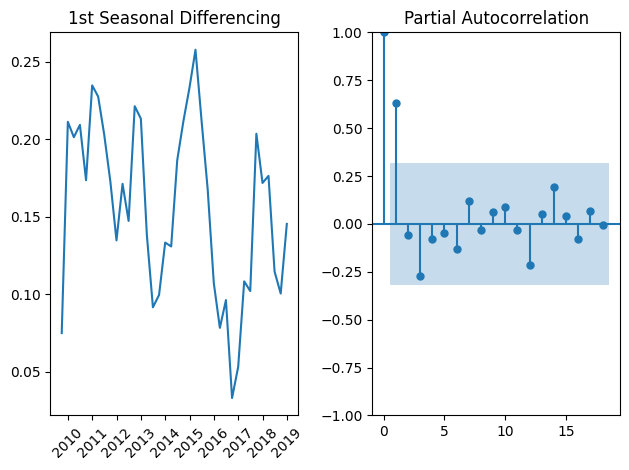

In [15]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(diff1s); axes[0].set_title('1st Seasonal Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(diff1s, ax=axes[1],lags=18)

# Rotaciona os rótulos do eixo X apenas nos gráficos à esquerda
for label in axes[0].get_xticklabels():
    label.set_rotation(45)
plt.tight_layout()
plt.show()

✅ **Conclusão**:

* Lag 1: forte → sugere componente AR(1);

* Lag 4 (sazonal): está dentro da banda → indica P = 0 .

In [16]:
p = 1
P = 0

## Definindo 'q'

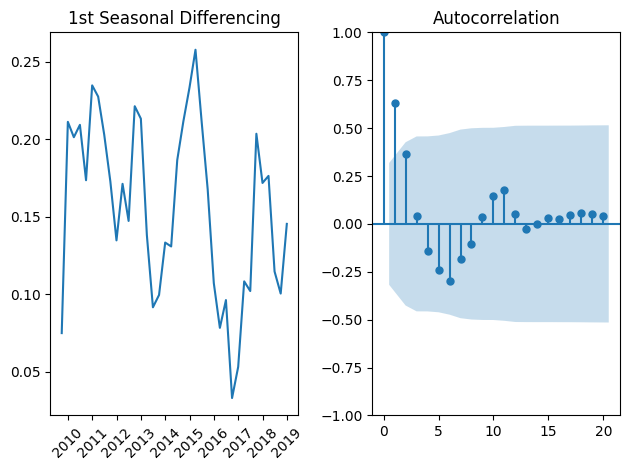

In [17]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(diff1s); axes[0].set_title('1st Seasonal Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(diff1s, ax=axes[1], lags=20)

# Rotaciona os rótulos do eixo X apenas nos gráficos à esquerda
for label in axes[0].get_xticklabels():
    label.set_rotation(45)
plt.tight_layout()

plt.show()

In [18]:
ljungbox_test(diff1s)


LJung-Box Test
H0:has no autocorrelation

p-valor = 0.02
alpha = 0.05
Data has autocorrelation


✅ **Conclusão**:
* Lag 1: significativamente diferente de zero → indica presença de componente MA(1);

* Lag 4 (sazonal): dentro da banda → indica Q = 0.

In [19]:
q = 1
Q = 0

# Modelo SARIMA

## SARIMA(1,0,1)(0,1,0)4

In [20]:
print(f'SARIMA({p},{d},{q})({P},{D},{Q}){s}')

SARIMA(1,0,1)(0,1,0)4


In [21]:
sarima_1010104 = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,s))
fitted_1010104 = sarima_1010104.fit()

In [22]:
# summary of fit model
print(fitted_1010104.summary())
# residuals
resid_1010104 = DataFrame(fitted_1010104.resid)
# summary stats of residuals
print(resid_1010104.describe())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   42
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 4)   Log Likelihood                  61.665
Date:                            Sun, 30 Mar 2025   AIC                           -117.331
Time:                                    23:48:46   BIC                           -112.418
Sample:                                09-30-2008   HQIC                          -115.583
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9550      0.054     17.587      0.000       0.849       1.061
ma.L1         -0.0060      0.321   

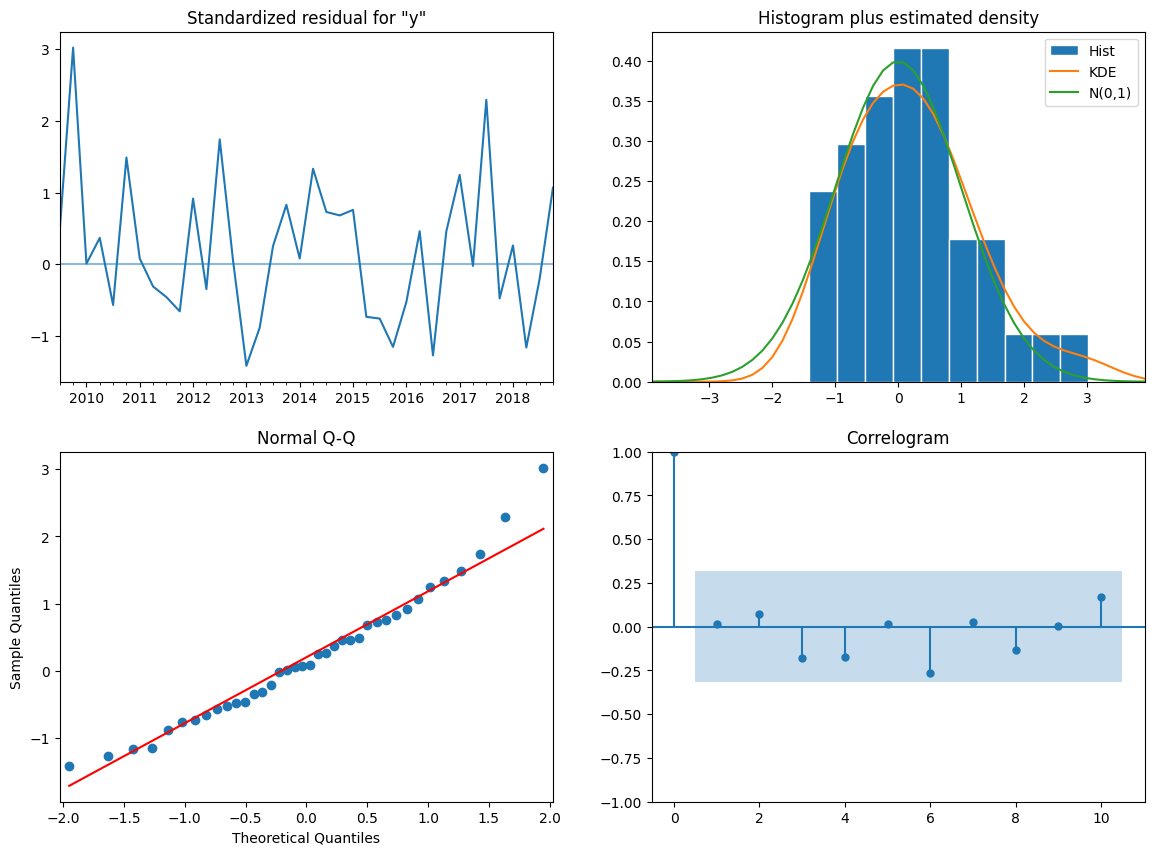

In [23]:
fig = fitted_1010104.plot_diagnostics(figsize=(14,10))
plt.show()

<Axes: xlabel='ds'>

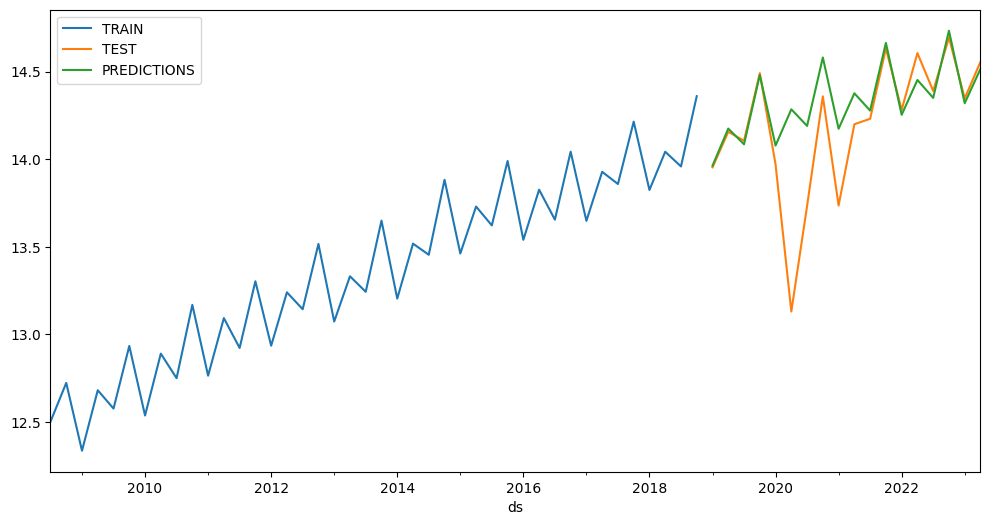

In [24]:
predictions_1010104 = predictions = fitted_1010104.forecast(len(test))
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':predictions_1010104}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


# Modelo AR

## AR(1)

In [25]:
print(f'AR({p})')
ar1 = SARIMAX(train, order=(p,0,0))
fitted_ar1 = ar1.fit()

AR(1)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -15.847
Date:                Sun, 30 Mar 2025   AIC                             35.694
Time:                        23:48:49   BIC                             39.169
Sample:                    09-30-2008   HQIC                            36.968
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.003    356.956      0.000       0.994       1.005
sigma2         0.1043      0.053      1.955      0.051      -0.000       0.209
Ljung-Box (L1) (Q):                  30.56   Jarque-

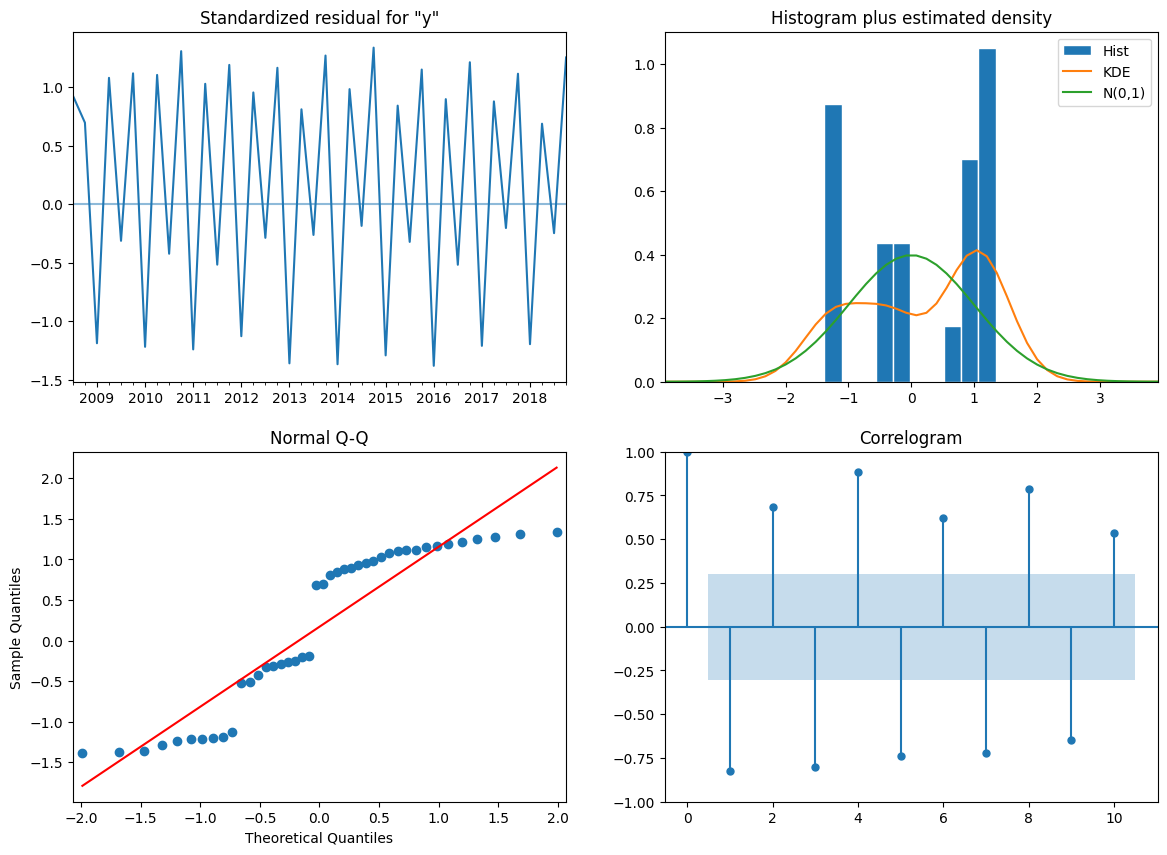

In [26]:
# summary of fit model
print(fitted_ar1.summary())
# residuals
resid_ar1 = DataFrame(fitted_ar1.resid)
# summary stats of residuals
print(resid_ar1.describe())
predictions_ar1 = predictions = fitted_ar1.forecast(len(test))
fig = fitted_ar1.plot_diagnostics(figsize=(14,10))
plt.show()

<Axes: xlabel='ds'>

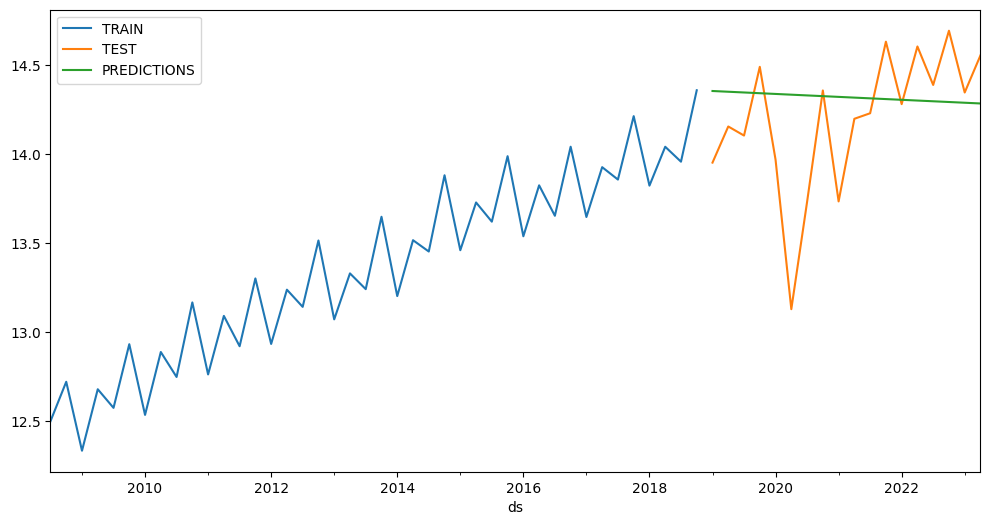

In [27]:
predictions_ar1 = predictions = fitted_ar1.forecast(len(test))
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':predictions_ar1}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


# Modelo MA

## MA(1)

In [28]:
print(f'MA({q})')
ma1 = SARIMAX(train, order=(0,0,q))
fitted_ma1 = ma1.fit()


MA(1)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -143.179
Date:                Sun, 30 Mar 2025   AIC                            290.359
Time:                        23:48:51   BIC                            293.834
Sample:                    09-30-2008   HQIC                           291.633
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9414      0.227      4.154      0.000       0.497       1.386
sigma2        50.8347     72.561      0.701      0.484     -91.381     193.051
Ljung-Box (L1) (Q):                  35.72   Jarque-

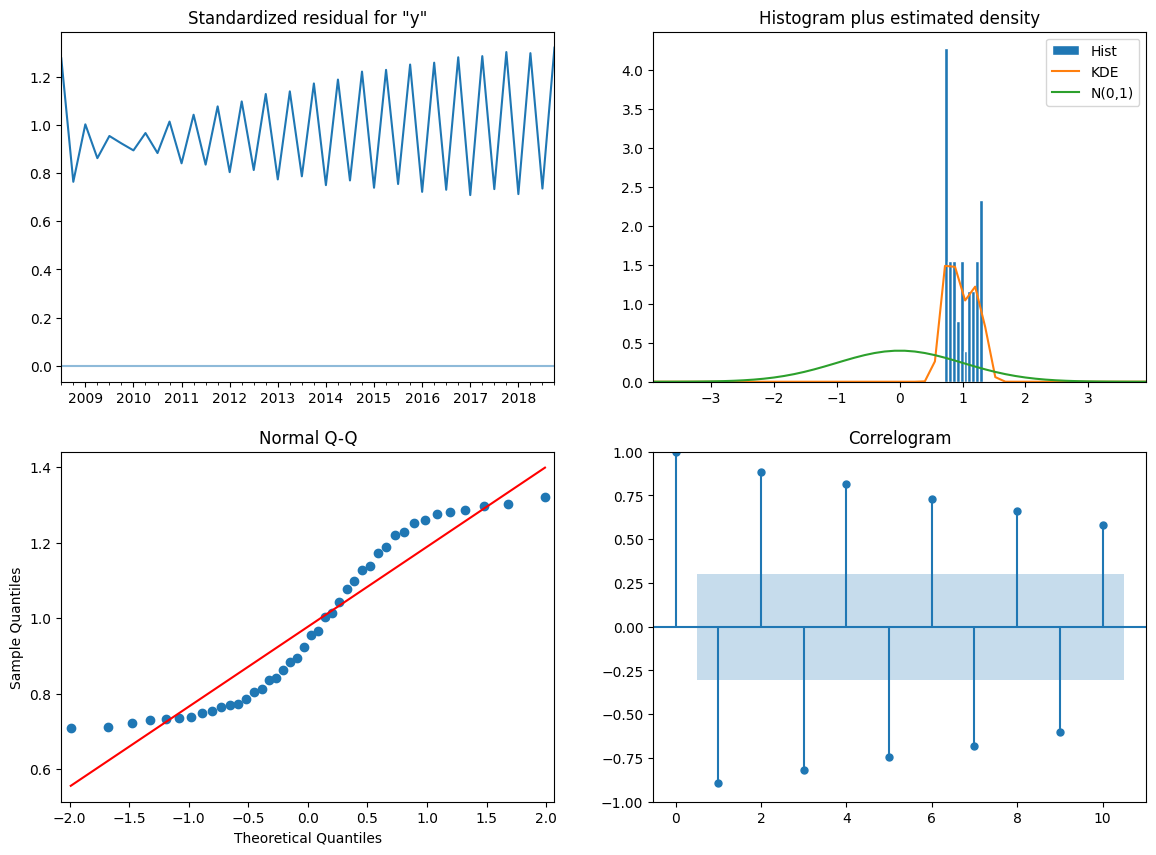

In [29]:
# summary of fit model
print(fitted_ma1.summary())
# residuals
resid_ma1 = DataFrame(fitted_ma1.resid)
# summary stats of residuals
print(resid_ma1.describe())
predictions_ma1 = predictions = fitted_ma1.forecast(len(test))
fig = fitted_ma1.plot_diagnostics(figsize=(14,10))
plt.show()

<Axes: xlabel='ds'>

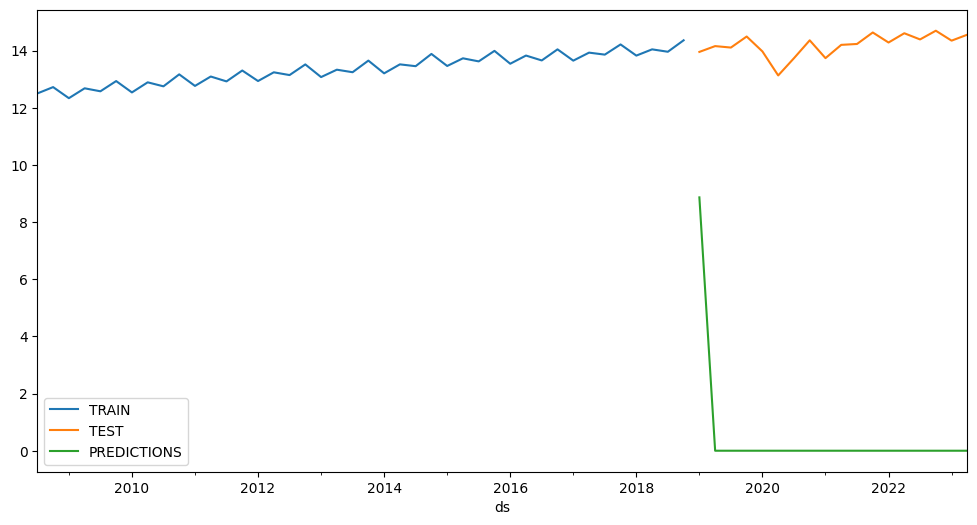

In [30]:
predictions_ma1 = predictions = fitted_ma1.forecast(len(test))
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':predictions_ma1}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


# Conclusion

In [31]:
def metrics(test, predictions):
  # Cálculo das métricas de avaliação
  mse = mean_squared_error(test['y'], predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(test['y'], predictions)
  r2 = r2_score(test['y'], predictions)

  # Calcular MAPE (Mean Absolute Percentage Error)
  mape = np.mean(np.abs((test['y'] - predictions) / test['y'])) * 100

  # Calcular SMAPE (Symmetric Mean Absolute Percentage Error)
  smape = np.mean(2 * np.abs(test['y'] - predictions) /
                (np.abs(test['y']) + np.abs(predictions))) * 100

  # Exibir as métricas
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")
  print(f"R²: {r2}")
  print(f"MAPE: {mape}")
  print(f"SMAPE: {smape}")


In [32]:
print(f'\nSARIMAX({p},{d},{q})({P},{D},{Q}){s}')
metrics(test, predictions_1010104)

print(f'\nAR({p})')
metrics(test, predictions_ar1)

print(f'\nMA({q})')
metrics(test, predictions_ma1)


SARIMAX(1,0,1)(0,1,0)4
MSE: 0.10342335887247263
RMSE: 0.32159502308411525
MAE: 0.16798975141418085
R²: 0.28493721797193217
MAPE: 1.2281604993354729
SMAPE: 1.2008144148826736

AR(1)
MSE: 0.16874307935012578
RMSE: 0.41078349449573287
MAE: 0.30300540836507966
R²: -0.16667933708155314
MAPE: 2.1769801488606286
SMAPE: 2.144739157040675

MA(1)
MSE: 192.36996920866014
RMSE: 13.86975014946773
MAE: 13.706258886414117
R²: -1329.0342094924033
MAPE: 96.47089106416415
SMAPE: 191.36735945582913
